In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import rich
print = rich.print
print("OpenCV version:", cv2.__version__)
print("Numpy version:", np.__version__)

OpenCV version: 4.8.1

Numpy version: 1.26.0

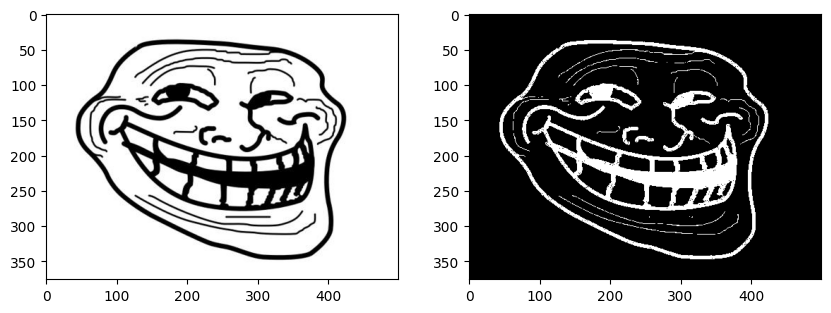

In [2]:
image = cv2.imread("./imgs/Trollface.jpg")
# Convert to B and W only img with a threshold of 127
bw = cv2.threshold(image, 12, 255, cv2.THRESH_BINARY)[1]
bw = cv2.cvtColor(bw, cv2.COLOR_BGR2GRAY)
# invert the image
bw = cv2.bitwise_not(bw)
# convert to 0 and 1 values
bw[bw > 0] = 1

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image)
ax[1].imshow(bw, cmap="gray")
plt.show()

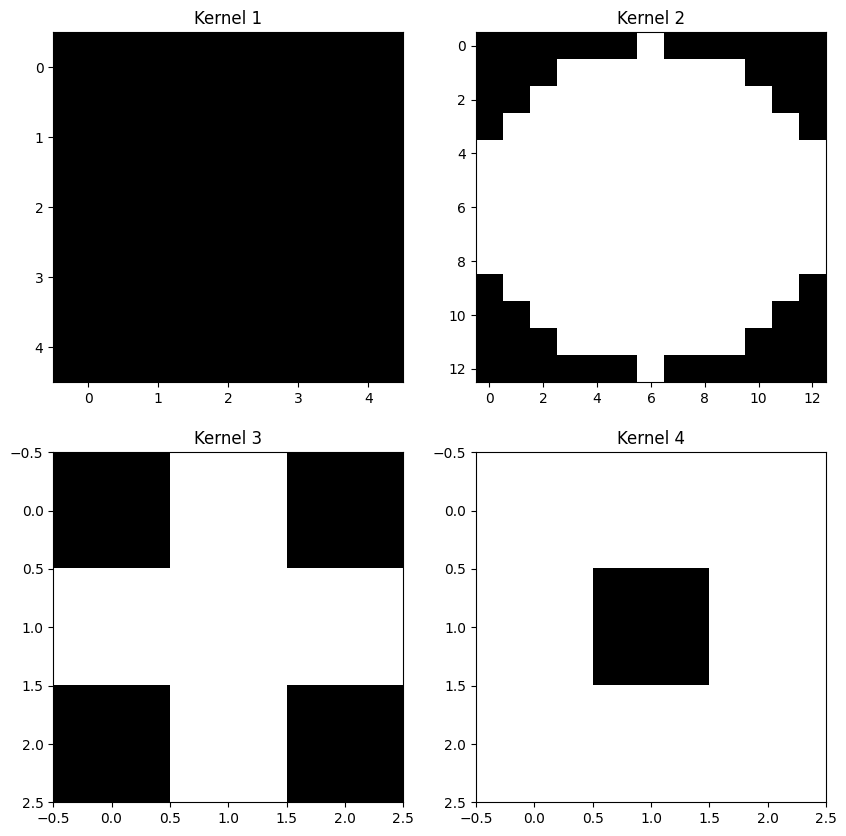

In [3]:
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13))
kernel3 = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
kernel4 = np.ones((3,3),np.uint8)
kernel4[1,1] = 0

ax,fig = plt.subplots(2,2,figsize=(10,10))
fig[0,0].imshow(kernel1, cmap="gray")
fig[0,0].set_title("Kernel 1")

fig[0,1].imshow(kernel2, cmap="gray")
fig[0,1].set_title("Kernel 2")

fig[1,0].imshow(kernel3, cmap="gray")
fig[1,0].set_title("Kernel 3")

fig[1,1].imshow(kernel4, cmap="gray")
fig[1,1].set_title("Kernel 4")

plt.show()

In [4]:
# using openCV
def hit_or_miss(bw_img: np.ndarray,kernel: np.ndarray)->np.ndarray:
    return cv2.morphologyEx(bw_img, cv2.MORPH_HITMISS, kernel)
def expansion(bw_img,kernel):
    return cv2.morphologyEx(bw_img, cv2.MORPH_DILATE, kernel)

In [5]:
def expansion(bw_img,kernel):
    # Create a new image with the same size of the original
    img_shape = bw_img.shape
    # Create a new image with the same size of the original
    new_img = np.zeros(img_shape)
    # Get the size of the kernel
    kernel_shape = kernel.shape
    # Get the center of the kernel
    centers = [int((kernel_shape[0]-1)/2),int((kernel_shape[1]-1)/2)]
    centerx = centers[0]
    centery = centers[1]
    # Iterate over the image
    for x in range( centerx,img_shape[0] - centerx):
        for y in range(centery,img_shape[1] - centery):
            # Iterate over the kernel
            slice_img = bw_img[x-centery:x+centery+1,y-centery:y+centery+1]
            # check if any pixel in the slice matches the kernel
            does_match = (kernel * slice_img).sum() > 0
            if(does_match):
                new_img[x,y] = 255
    return new_img

def hit_or_miss(bw_img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    # Create an output image filled with zeros
    output = np.zeros_like(bw_img)
    kernel_w , kernel_h = kernel.shape
    half_w = kernel_w // 2
    half_h = kernel_h // 2
    # Iterate over the image
    for i in range(half_w, bw.shape[0]-half_w):
        for j in range(half_h, bw.shape[1]-half_h):
            # Extract the neighborhood
            neighborhood = bw[i-half_w:i+half_w+1, j-half_h:j+half_h+1].flatten()
            kernel_f = kernel.flatten()
            #is_match = all([x == y and kernel_f == 1 for x, y in zip(kernel_f, neighborhood)])
            is_match = True
            for x, y in zip(kernel_f, neighborhood):
                if x == 1 and x != y:
                    is_match = False
                    break
            if is_match:
                output[i,j] = 1
    return output

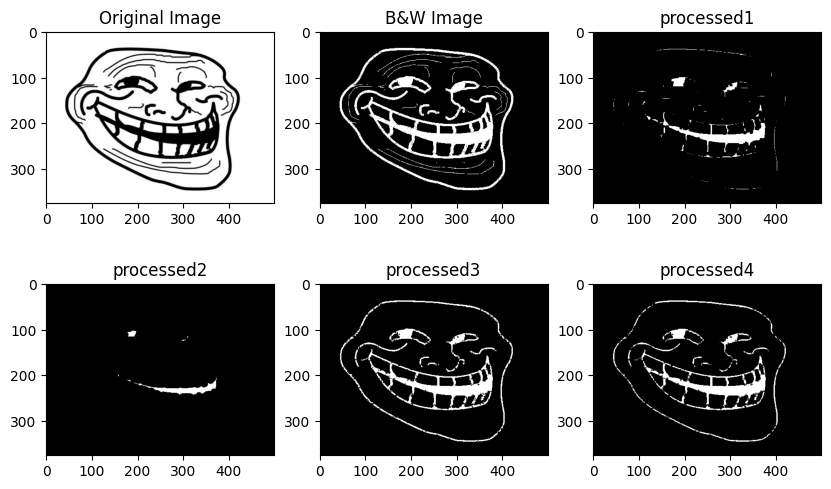

In [6]:
data = {
"processed1":  hit_or_miss(bw,kernel1) ,
"processed2":  hit_or_miss(bw,kernel2) ,
"processed3": hit_or_miss(bw,kernel3) ,
"processed4":  hit_or_miss(bw,kernel4),
"Original Image": image,
"B&W Image": bw
}

_,plot = plt.subplots(2,3,figsize=(10,6))
plot[0,0].imshow(data["Original Image"])
plot[0,0].set_title("Original Image")

plot[0,1].imshow(data["B&W Image"], cmap="gray")
plot[0,1].set_title("B&W Image")

plot[0,2].imshow(data["processed1"], cmap="gray")
plot[0,2].set_title("processed1")

plot[1,0].imshow(data["processed2"], cmap="gray")
plot[1,0].set_title("processed2")

plot[1,1].imshow(data["processed3"], cmap="gray")
plot[1,1].set_title("processed3")

plot[1,2].imshow(data["processed4"], cmap="gray")
plot[1,2].set_title("processed4")

plt.show()

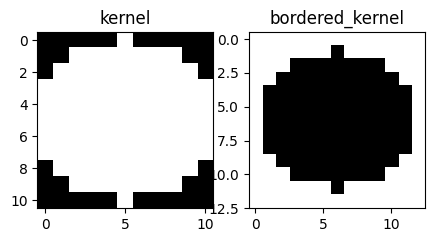

In [7]:
kernel_r = 11
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_r,kernel_r))
w,h = kernel.shape
# add a border to the kernel
bordered_kernel = np.zeros((w+2,h+2),dtype=np.uint8)
bordered_kernel[1:-1,1:-1] = kernel
bordered_kernel = 1-bordered_kernel
# invert kernel
#kernel = 1-kernel
ax,fig = plt.subplots(1,2,figsize=(5,5))
fig[0].imshow(kernel, cmap="gray")
fig[0].set_title("kernel")

fig[1].imshow(bordered_kernel, cmap="gray")
fig[1].set_title("bordered_kernel")

plt.show()

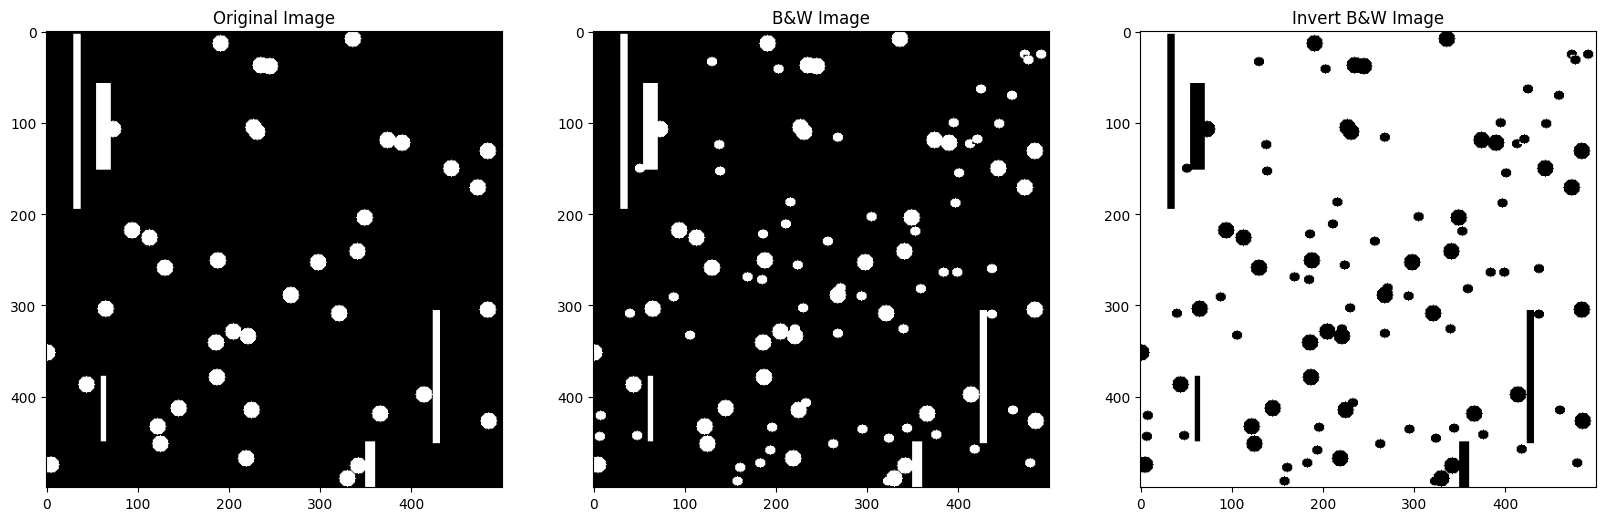

In [8]:
import random
# set seed
img_size = 500
img = np.zeros((img_size,img_size),dtype=np.uint8)
max_size = 20
min_size = 3

# paste the kernel randomly to the img
for i in range(60):
    shape_x,shape_y = kernel.shape
    x = random.randint(0,img_size - shape_x)
    y = random.randint(0,img_size - shape_y)
    img[x:x+shape_x,y:y+shape_y] = kernel

# create random rectangles
for i in range(5):
    x1 = random.randint(0,img_size)
    y1 = random.randint(0,img_size)
    x2 = x1 + random.randint(min_size,max_size)
    y2 = y1 + random.randint(min_size,max_size*10)
    cv2.rectangle(img,(x1,y1),(x2,y2),255,-1)

for i in range(40):
    x1 = random.randint(0,img_size)
    y1 = random.randint(0,img_size)
    r = 9
    cv2.circle(img,(x1,y1),r,255,-1)
    
bw = img.copy()
bw[bw>0] = 1
invert_bw = 1-bw


_,fig = plt.subplots(1,3,figsize=(20,20))
fig[0].imshow(img, cmap="gray")
fig[0].set_title("Original Image")

fig[1].imshow(bw, cmap="gray")
fig[1].set_title("B&W Image")

fig[2].imshow(invert_bw, cmap="gray")
fig[2].set_title("Invert B&W Image")

plt.show()

In [9]:
#
find_kernel = hit_or_miss(bw,kernel)
#
find_inverse_kernel = hit_or_miss(invert_bw, bordered_kernel)
#
intersection = find_kernel & find_inverse_kernel

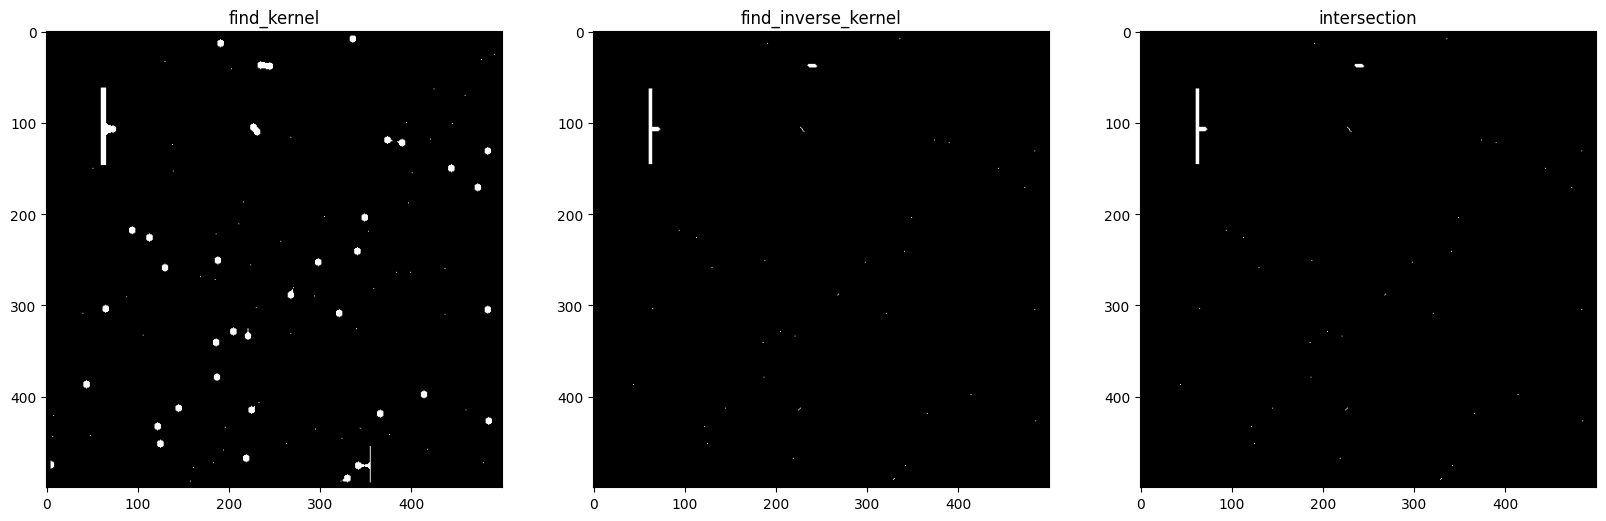

In [10]:
ax,fig = plt.subplots(1,3,figsize=(20,20))
fig[0].imshow(find_kernel, cmap="gray")
fig[0].set_title("find_kernel")

fig[1].imshow(find_inverse_kernel, cmap="gray")
fig[1].set_title("find_inverse_kernel")

fig[2].imshow(intersection, cmap="gray")
fig[2].set_title("intersection")
plt.show()

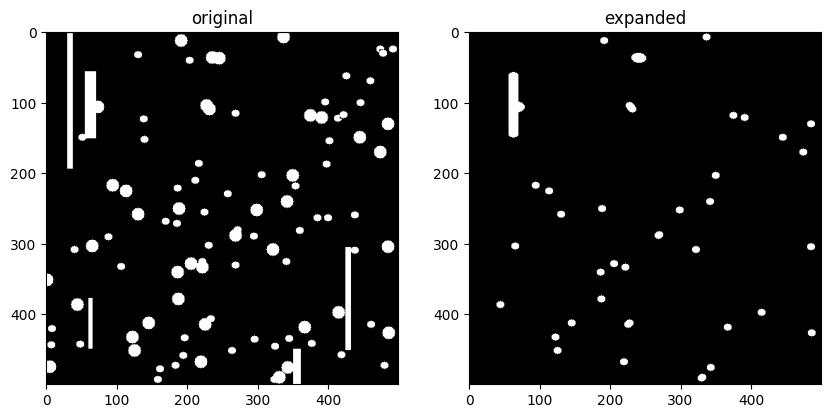

In [11]:
# expand the intersection pixels with the kernel
expanded = cv2.morphologyEx(intersection, cv2.MORPH_DILATE, kernel)
ax,fig = plt.subplots(1,2,figsize=(10,10))
fig[0].imshow(bw, cmap="gray")
fig[0].set_title("original")

fig[1].imshow(expanded, cmap="gray")
fig[1].set_title("expanded")
plt.show()